In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom, ttest_rel, t, truncnorm, nct, multivariate_t, beta, nct, cauchy, ttest_rel
from scipy.integrate import quad
from scipy.special import gamma


In [31]:
def logjoint(var, par, mu = 0.5, sigma = 1):
    n1, k1, n2, k2, H0 = par
    beta, psi = var

    p1 = np.exp(beta-(psi/2))/(1+np.exp(beta-(psi/2)))
    p2 = np.exp(beta+(psi/2))/(1+np.exp(beta+(psi/2)))
        
    logbin1 = binom.logpmf(k1, n1, p1)
    logbin2 = binom.logpmf(k2, n2, p2)
        
    if H0:
        log_joint = logbin1 +logbin2 + norm.logpdf(beta) 
    else:            
        log_joint = logbin1 +logbin2 + norm.logpdf(beta) + norm.logpdf(psi, mu, sigma)

    return log_joint


In [32]:
eps = 1e-4

def der_x(x, fun, par):
    f1 = fun([x[0]+eps, x[1]], par)
    f2 = fun([x[0]-eps, x[1]], par)
    return (f1-f2)/(2*eps)

def der_y(x, fun, par):
    f1 = fun([x[0], x[1]+eps], par)
    f2 = fun([x[0], x[1]-eps], par)
    return (f1-f2)/(2*eps)

def der_xy(x, fun, par):
    f1 = der_x([x[0], x[1]+eps], fun, par)
    f2 = der_x([x[0], x[1]-eps], fun, par)
    return (f1-f2)/(2*eps)

def der_xx(x, fun, par):
    f1 = der_x([x[0]+eps, x[1]], fun, par)
    f2 = der_x([x[0]-eps, x[1]], fun, par)
    return (f1-f2)/(2*eps)

def der_yy(x, fun, par):
    f1 = der_y([x[0], x[1]+eps], fun, par)
    f2 = der_y([x[0], x[1]-eps], fun, par)
    return (f1-f2)/(2*eps)

def Hessian(x, fun, par):
    return np.array([[der_xx(x, fun, par), der_xy(x, fun, par)], 
                    [der_xy(x, fun, par), der_yy(x, fun, par)]])

def sigma_sq(x, fun, par):
    second_derivative = der_xx(x, fun, par)
    return -1/second_derivative



In [33]:
def mode_logjoint(par, H0=True):
    beta = 0
    psi = 0
    beta_old = -100
    psi_old = -100
    if H0:
        while np.abs(beta_old - beta) > 0.01:
            beta_old = beta
            db = der_x([beta, psi], logjoint, par)
            d2b = der_xx([beta, psi], logjoint, par)
            beta = beta - (db/d2b)
            log_joint = logjoint([beta, psi], par)
            
    else:
        while np.abs(beta_old - beta) > 0.01 or np.abs(psi_old - psi) > 0.01:
            beta_old = beta
            psi_old = psi
            db = der_x([beta, psi], logjoint, par)
            dp = der_y([beta, psi], logjoint, par)
            d2b = der_xx([beta, psi], logjoint, par)
            d2p = der_yy([beta, psi], logjoint, par)
            beta = beta - (db/d2b)
            psi = psi - (dp/d2p)
            log_joint = logjoint([beta, psi], par)
            
    return beta, psi, log_joint

In [34]:
def lik_H0(data, mu_beta = 0, sigma_beta = 1):
    par = data + [True]
    beta_star, _, l_star = mode_logjoint(par)
    sigma0 = sigma_sq([beta_star, 0], logjoint, par)
    return np.sqrt(2*np.pi*sigma0)*np.exp(l_star)

def lik_H1(data, mu_beta = 0, sigma_beta = 1, mu_psi = 0, sigma_psi = 1):
    par = data + [False]
    beta_star, psi_star, l_star = mode_logjoint(par, H0 = False)
    
    H1 = Hessian([beta_star, psi_star], logjoint, par)
    sigma1 = np.linalg.inv(-H1)
    
    lik = 2*np.pi*np.sqrt(np.linalg.det(sigma1))*np.exp(l_star)
    
    return lik, psi_star, sigma1[1, 1]


In [35]:
def posterior(data):

    L0 = lik_H0(data)
    L1, psi, sigma = lik_H1(data)

    Bm0 = (t.cdf(0, loc = psi, scale = sigma, df=5)/0.5)*(L1/L0)
    Bp0 = ((1-t.cdf(0, loc = psi, scale = sigma, df=5))/0.5)*(L1/L0)
    #print(Bm0, Bp0)

    post_0P = Bp0/(Bp0+1)
    return Bm0, Bp0, post_0P


In [36]:
n_raters = 9
n_sim = 1000
a = 18
b = 2

post_average = []
post_threshold = []
BF_average = []
BF_threshold = []
for N in np.arange(100, 2100, 100):
#N = 200
#for p in np.arange(0.05, 1, 0.05):
#for n_raters in np.arange(3, 101, 2):
    post = []
    BF = []
    for i in range(n_sim):
        #p = beta.rvs(a, b, size = N)
        p = beta.rvs(a, b)
        attempt1 = N
        attempt2 = n_raters*N
        #success1 = 0
        #success2 = 0
        #for n in range(N):
        #    success1 += np.sum(np.random.choice([0,1], size = 1, p = [1-p[n], p[n]]))
        #    success2 += np.sum(np.random.choice([0,1], size = n_raters, p = [1-p[n], p[n]]))            
        success1 = np.sum(np.random.choice([0,1], size = N, p = [1-p, p]))
        success2 = np.sum(np.random.choice([0,1], size = n_raters*N, p = [1-p, p]))
        
        
        data = [attempt1, success1, attempt2, success2]
        Bm0, Bp0, post_plus = posterior(data)
        post_0P = 1 - post_plus
        BF.append(1/Bp0)
        post.append(post_0P)
        
    post_average.append(np.mean(post))
    post_threshold.append(np.mean(np.array(post)>=0.95))
    BF_average.append(np.mean(BF))
    BF_threshold.append(np.mean(np.array(BF)>=np.sqrt(10)))


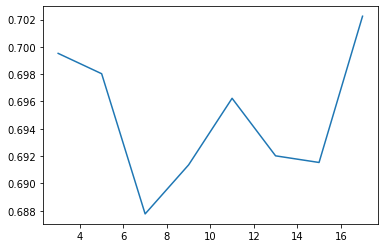

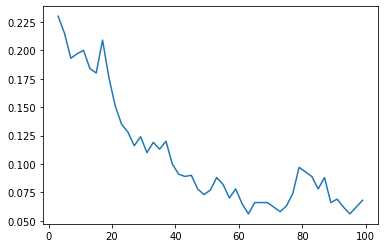

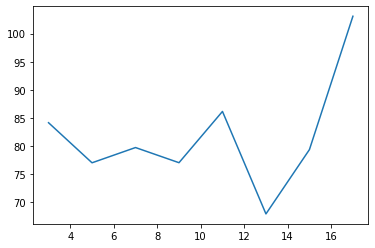

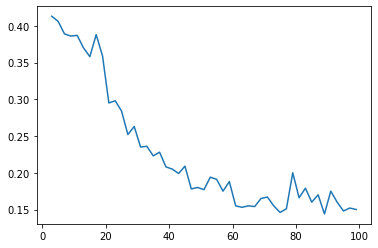

In [10]:
plt.plot(np.arange(3, 101, 2), post_average)
plt.show()

plt.plot(np.arange(3, 101, 2), post_threshold)
plt.show()

plt.plot(np.arange(3, 101, 2), BF_average)
plt.show()

plt.plot(np.arange(3, 101, 2), BF_threshold)
plt.show()

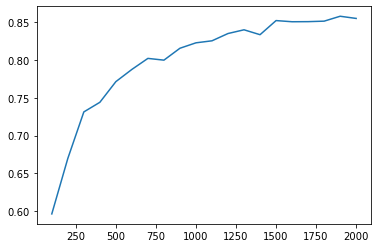

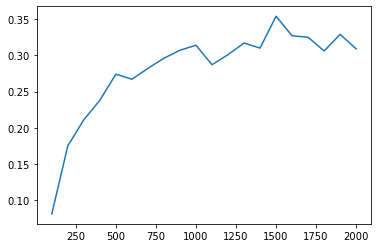

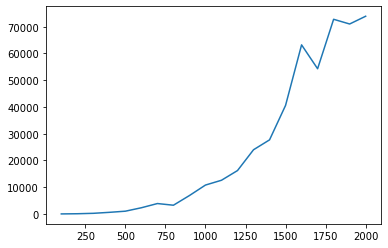

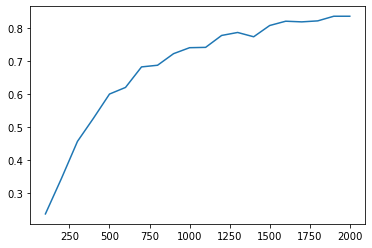

In [37]:
plt.plot(np.arange(100, 2100, 100), post_average)
plt.show()

plt.plot(np.arange(100, 2100, 100), post_threshold)
plt.show()

plt.plot(np.arange(100, 2100, 100), BF_average)
plt.show()

plt.plot(np.arange(100, 2100, 100), BF_threshold)
plt.show()

In [8]:
_, _, post_ = posterior([100, 90, 100, 99])
print(post_)

0.9279805847225988


In [23]:
p2 = 0.9
p1 = 0.1

psi = np.log(p2/(1-p2)) - np.log(p1/(1-p1))
print(psi)

4.394449154672438


In [116]:
def numerator(delta, tstat, n):
    df =n-1
    return (nct.pdf(tstat, df, np.sqrt(n)*delta))*(cauchy.pdf(delta, 0, 0.707))

def lognum(delta, tstat, n):
    df = n-1
    return nct.logpdf(tstat, df, np.sqrt(n)*delta) + cauchy.logpdf(delta, 0, 0.707)
    
def find_mode(tstat, n, low, high, step=0.01):
    # Generate random input values within the specified range
    x_samples = np.arange(low, high+step, step)
    
    # Evaluate the function at each of the sampled input values
    y_samples = np.array([numerator(x, tstat, n) for x in x_samples])
    
    mask = np.isnan(y_samples)
    y_samples = y_samples[~mask]
    x_samples = x_samples[~mask] 
    
    mask = np.isinf(np.abs(y_samples))
    y_samples = y_samples[~mask]
    x_samples = x_samples[~mask] 

    # Find the input value that corresponds to the maximum function value
    mode_index = np.argmax(y_samples)
    mode = x_samples[mode_index]
    
    return mode


def integral_limits(data, tstat, start=1e-2, step=1e-2, tolerance=1e-15):
    delta = np.mean(data)
    n = len(data)  
    mode = find_mode(tstat, n, -np.abs(delta)-1, np.abs(delta)+1)  
    #print(mode)
    # Optimize lower bound
    diff = 100
    prev_integral = 0
    lower_limit = mode - start
    while True:
        integral_value, error = quad(numerator, lower_limit, mode, args=(tstat, n))
        diff = np.abs(integral_value - prev_integral)
        if diff < tolerance:
            break
        prev_integral = integral_value
        lower_limit -= step
       
    # Optimize upper bound
    upper_limit = mode + (mode-lower_limit)
    #prev_integral = 0
    #diff = 100
    #upper_limit = mode + start
    #while True:
    #    integral_value, error = quad(numerator, mode, upper_limit, args=(tstat, n))
    #    diff = np.abs(integral_value - prev_integral)
    #    if diff < tolerance:
    #        break
    #    prev_integral = integral_value
    #    upper_limit += step
    integral_value, error = quad(numerator, lower_limit, upper_limit, args=(tstat, n))
    return integral_value, lower_limit+step, upper_limit-step
        
    
def Bayes_factor_10(data1, data2):
    data = (data1-data2)/np.std(data1-data2)
    delta = np.mean(data)
    n = len(data)
    tstat = ttest_rel(data1, data2).statistic 
    num, low, high = integral_limits(data, tstat)
    #print(low, high)
    den = t.pdf(tstat, n-1)
    return num/den, low, high

def Bayes_factor_plus0(data1, data2):
    data = (data1-data2)/np.std(data1-data2)
    delta = np.mean(data)
    n = len(data)
    tstat = ttest_rel(data1, data2).statistic
    B10, low, high = Bayes_factor_10(data1, data2)
    if low > 0:
        return np.inf
    elif high < 0:
        return 0
    else:
        pos = quad(numerator, 0, high, args=(tstat, n))[0]
        tot = quad(numerator, low, high, args=(tstat, n))[0]
        Bplus1 = (pos/tot)/0.5
        return B10*Bplus1

0.7890000405747398


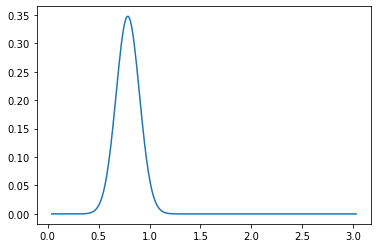

B+0: 3303366198.8391347
p(rsv1>rsv2) = 99.99999996972785 %


In [117]:
rvs1 = norm.rvs(loc=3, scale=1, size=100)
rvs2 = norm.rvs(loc=2, scale=1, size=100)

data = (rvs1-rvs2)/np.std(rvs1-rvs2)
delta = np.mean(data)
n = len(data)
tstat = ttest_rel(rvs1, rvs2).statistic

#nct.pdf(tstat, n-1, np.sqrt(n)*delta)
v = []
vv = []
vvv = []
for x in np.arange(0.04, 3.04, 0.01):
    #v.append(numerator(x, 72, 100))
    v.append(nct.pdf(tstat, n-1, np.sqrt(n)*x))
    #vvv.append(norm.pdf(x, loc=delta, scale=0.4)/2.5)

print(delta)
plt.plot(np.arange(0.04, 3.04, 0.01),v)
#plt.plot(np.arange(0.04, 3.04, 0.01),vv)
#plt.plot(np.arange(0.04, 3.04, 0.01),vvv)

plt.show()


Bplus0 = Bayes_factor_plus0(rvs1, rvs2)
print('B+0:', Bplus0)
if Bplus0 == np.inf:
    print('p(rsv1>rsv2) =', 100, '%')
else:
    print('p(rsv1>rsv2) =', Bplus0/(1+Bplus0)*100, '%')

In [120]:
post_average = []
post_threshold = []
BF_average = []
BF_threshold = []
for N in np.arange(10, 510, 10):
    post = []
    BF = []
    for i in range(1000):
        rvs1 = np.array([np.random.randint(1, 7) for _ in range(N)])
        rvs2 = np.array([np.random.randint(1, 7) for _ in range(N)])
        Bplus0 = Bayes_factor_plus0(rvs1, rvs2)
        if Bplus0 == np.inf:
            posterior = 1
            BF.append(0)
        else:
            posterior =  Bplus0/(1+Bplus0)
            BF.append(1/Bplus0)
        
        post.append(1-posterior)
    post_average.append(np.mean(post))
    BF_average.append(np.mean(BF))
    post_threshold.append(np.mean(np.array(post)>=0.95))
    BF_threshold.append(np.mean(np.array(BF)>=np.sqrt(10)))

C:\Users\franc\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:6402: RuntimeWarning: overflow encountered in exp
  Px = np.exp(trm1)
C:\Users\franc\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:6408: RuntimeWarning: invalid value encountered in multiply
  Px *= trm1+trm2


ZeroDivisionError: division by zero

ValueError: x and y must have same first dimension, but have shapes (50,) and (34,)

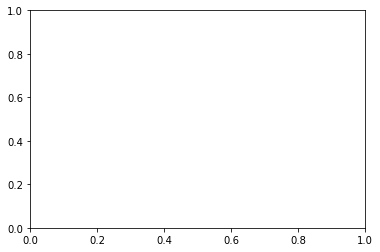

In [121]:
plt.plot(np.arange(10, 510, 10), BF_threshold)

400